In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

# Reproducibility
RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

# Output folder
OUT_DIR = Path("outputs_part1_kmeans")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Outputs will be saved to:", OUT_DIR.resolve())


Outputs will be saved to: C:\Users\Admin\Downloads\outputs_part1_kmeans


In [ ]:
'''Part 1 (K-means) - Experimental protocol

For each dataset:
1) Load data (X features, y labels). NOTE: y is NOT used for training K-means.
2) Preprocess:
   - Handle missing values (not needed for Iris/Wine from sklearn)
   - Standardize features (zero mean, unit variance) because K-means uses Euclidean distance.
3) Run K-means for many values of k (we use k in [2..10]):
   - init='k-means++' (centroid initialization)
   - n_init=30 (multiple runs with different initial seeds to reduce sensitivity)
   - max_iter=300, tol=1e-4 (defaults)
   - random_state fixed for reproducibility
4) Evaluate clustering quality:
   - Internal metrics: Silhouette (higher better), Davies-Bouldin (lower better),
     Calinski-Harabasz (higher better), Inertia/SSE (for elbow curve).
   - External metrics (optional because labels exist): ARI, NMI.
5) Compare results across different k and choose a reasonable k
   (often: high silhouette + elbow in inertia + interpretability).
'''


In [ ]:
'''Centroid initialization (K-means++)

We use init='k-means++' instead of random initialization.

- Pick the first centroid uniformly at random from the data points.
- For each next centroid: compute the distance D(x) from each point x to its nearest
  chosen centroid, then sample a new centroid with probability proportional to D(x)^2.

This tends to spread initial centroids out, improves convergence speed, and reduces
the risk of poor local minima compared to random seeding.
'''


In [2]:

def eval_clustering(Xfeat, pred_labels, true_labels=None):
    """Return a dict of clustering-quality scores."""
    out = {
        "silhouette": silhouette_score(Xfeat, pred_labels),
        "davies_bouldin": davies_bouldin_score(Xfeat, pred_labels),
        "calinski_harabasz": calinski_harabasz_score(Xfeat, pred_labels),
    }
    if true_labels is not None:
        out["ARI"] = adjusted_rand_score(true_labels, pred_labels)
        out["NMI"] = normalized_mutual_info_score(true_labels, pred_labels)
    return out


def kmeans_over_k(X, y=None, k_values=range(2, 11), n_init=30, random_state=0):
    """Run KMeans for many k and return a DataFrame of metrics."""
    rows = []
    for k in k_values:
        km = KMeans(
            n_clusters=k,
            init="k-means++",
            n_init=n_init,
            max_iter=300,
            tol=1e-4,
            random_state=random_state,
        )
        labels = km.fit_predict(X)

        metrics = eval_clustering(X, labels, true_labels=y)
        metrics.update({
            "k": k,
            "inertia": km.inertia_,  # WCSS / SSE
        })
        rows.append(metrics)

    df = pd.DataFrame(rows).sort_values("k").reset_index(drop=True)
    return df


def plot_metric_vs_k(df, metric, title, out_path):
    plt.figure()
    plt.plot(df["k"], df[metric], marker="o")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel(metric.replace("_", " ").title())
    plt.title(title, fontsize=20)
    plt.grid(True)
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()


def choose_best_k(df, metric="silhouette"):
    best_row = df.loc[df[metric].idxmax()]
    return int(best_row["k"]), float(best_row[metric])


In [3]:
'''Dataset 1: IRIS (UCI) - Load + Preprocess'''

from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
df_iris = iris.frame.copy()
df_iris.rename(columns={"target": "label"}, inplace=True)

X_iris = df_iris.drop(columns=["label"]).values
y_iris = df_iris["label"].values

print("Iris shape:", X_iris.shape)
print("Iris labels:", np.unique(y_iris))

# Standardize
scaler = StandardScaler()
X_iris_std = scaler.fit_transform(X_iris)

iris_dir = OUT_DIR / "iris"
iris_dir.mkdir(parents=True, exist_ok=True)


Iris shape: (150, 4)
Iris labels: [0 1 2]


e:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

,silhouette,davies_bouldin,calinski_harabasz,ARI,NMI,k,inertia
0,0.581750,0.593313,251.349339,0.568116,0.733680,2,222.361705
1,0.459948,0.833595,241.904402,0.620135,0.659487,3,139.820496
2,0.386941,0.869814,207.265914,0.472818,0.597298,4,114.092547
3,0.345511,0.945173,203.267419,0.420481,0.589862,5,90.807592
4,0.325677,1.051857,187.139278,0.356338,0.539743,6,80.022496
5,0.332280,1.065384,175.852294,0.408775,0.576439,7,71.612565
6,0.336483,1.007090,175.094105,0.398637,0.605034,8,62.296242
7,0.350743,0.904012,177.264305,0.350963,0.550072,9,54.261572
8,0.348607,0.895873,181.917986,0.332333,0.572263,10,47.263716


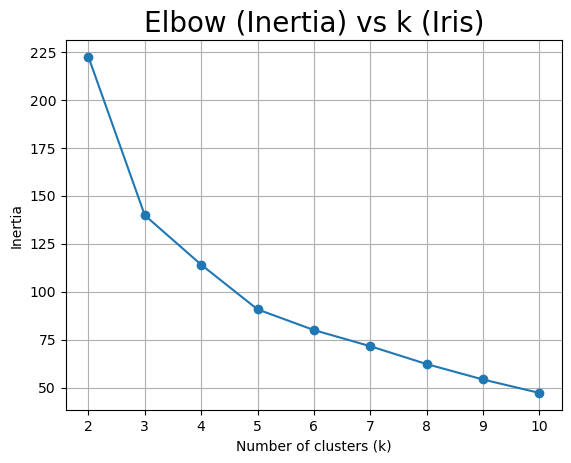

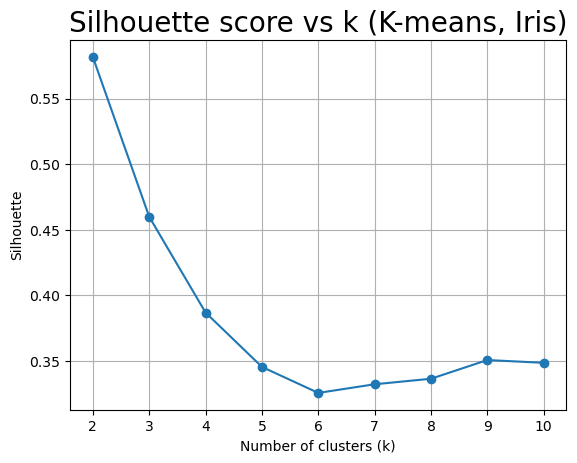

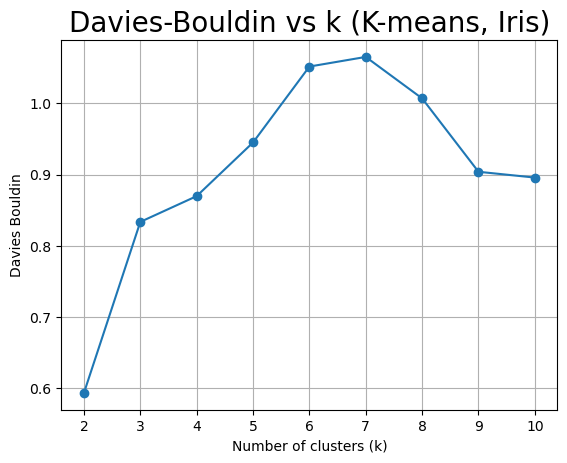

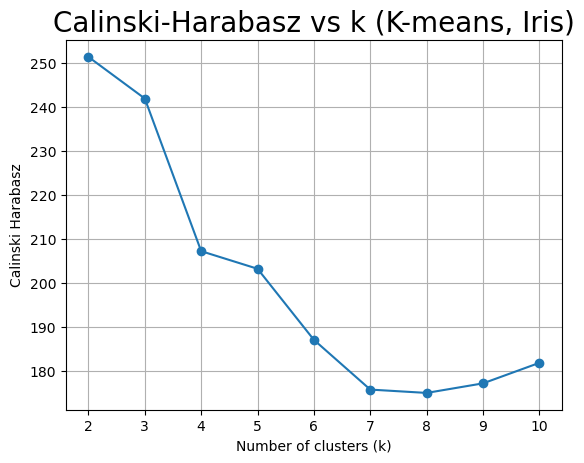

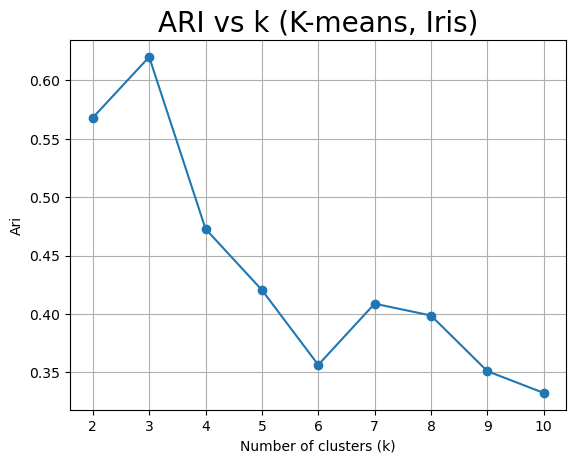

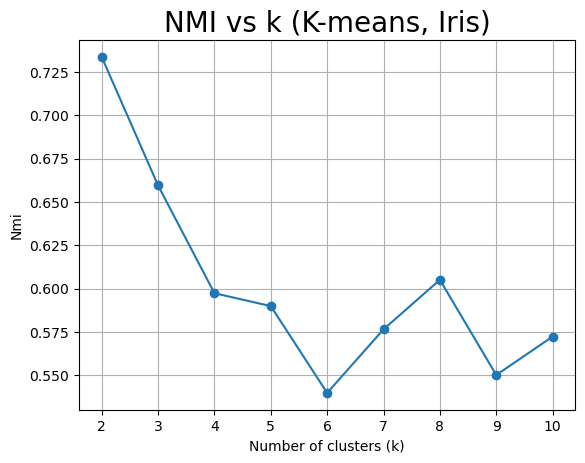

Best k by silhouette (Iris): k = 2, silhouette = 0.5818


In [4]:
'''IRIS - Run KMeans for different k + plot metrics'''

k_values = range(2, 11)  # [2..10]
df_iris_metrics = kmeans_over_k(X_iris_std, y=y_iris, k_values=k_values, n_init=30, random_state=RANDOM_STATE)
display(df_iris_metrics)

# Save table
df_iris_metrics.to_csv(iris_dir / "iris_kmeans_metrics.csv", index=False)

# Plots required for Part 1 (no PCA)
plot_metric_vs_k(df_iris_metrics, "inertia", "Elbow (Inertia) vs k (Iris)", iris_dir / "iris_elbow_inertia.png")
plot_metric_vs_k(df_iris_metrics, "silhouette", "Silhouette score vs k (K-means, Iris)", iris_dir / "iris_silhouette_vs_k.png")
plot_metric_vs_k(df_iris_metrics, "davies_bouldin", "Davies-Bouldin vs k (K-means, Iris)", iris_dir / "iris_dbi_vs_k.png")
plot_metric_vs_k(df_iris_metrics, "calinski_harabasz", "Calinski-Harabasz vs k (K-means, Iris)", iris_dir / "iris_ch_vs_k.png")

# Optional (because Iris has labels)
plot_metric_vs_k(df_iris_metrics, "ARI", "ARI vs k (K-means, Iris)", iris_dir / "iris_ari_vs_k.png")
plot_metric_vs_k(df_iris_metrics, "NMI", "NMI vs k (K-means, Iris)", iris_dir / "iris_nmi_vs_k.png")

best_k_iris, best_s_iris = choose_best_k(df_iris_metrics, metric="silhouette")
print(f"Best k by silhouette (Iris): k = {best_k_iris}, silhouette = {best_s_iris:.4f}")


In [5]:
'''Dataset 2: WINE (UCI) - Load + Preprocess'''

from sklearn.datasets import load_wine

wine = load_wine(as_frame=True)
df_wine = wine.frame.copy()
df_wine.rename(columns={"target": "label"}, inplace=True)

X_wine = df_wine.drop(columns=["label"]).values
y_wine = df_wine["label"].values

print("Wine shape:", X_wine.shape)
print("Wine labels:", np.unique(y_wine))

# Standardize
scaler = StandardScaler()
X_wine_std = scaler.fit_transform(X_wine)

wine_dir = OUT_DIR / "wine"
wine_dir.mkdir(parents=True, exist_ok=True)


Wine shape: (178, 13)
Wine labels: [0 1 2]


e:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

,silhouette,davies_bouldin,calinski_harabasz,ARI,NMI,k,inertia
0,0.259317,1.525997,69.523332,0.374314,0.478246,2,1658.758852
1,0.284859,1.389188,70.940008,0.897495,0.875894,3,1277.928489
2,0.261435,1.802502,56.186148,0.772796,0.814988,4,1175.378999
3,0.232972,1.733004,47.309036,0.685532,0.748201,5,1105.140961
4,0.195992,1.812327,41.812450,0.544549,0.639343,6,1044.469771
5,0.180155,1.803965,38.320975,0.479034,0.610007,7,986.950586
6,0.158096,1.769246,35.209934,0.406436,0.569508,8,944.558886
7,0.144671,1.709627,34.030195,0.465990,0.652876,9,886.285508
8,0.134699,1.772989,31.296619,0.325117,0.561493,10,864.528151


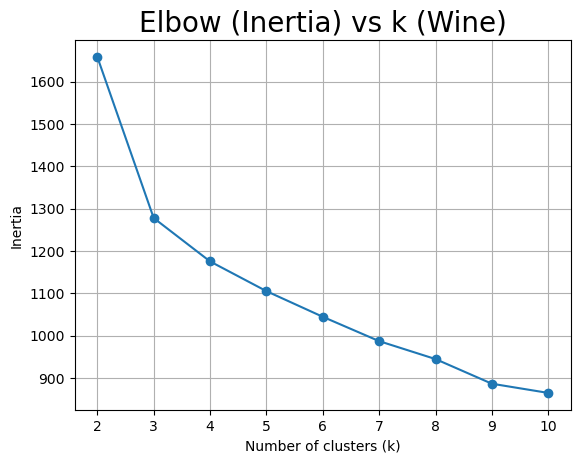

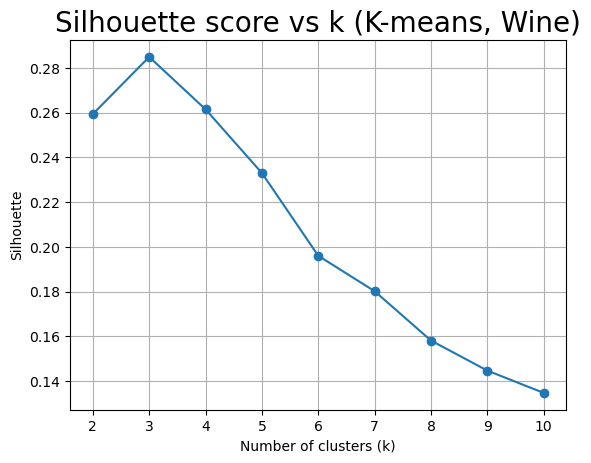

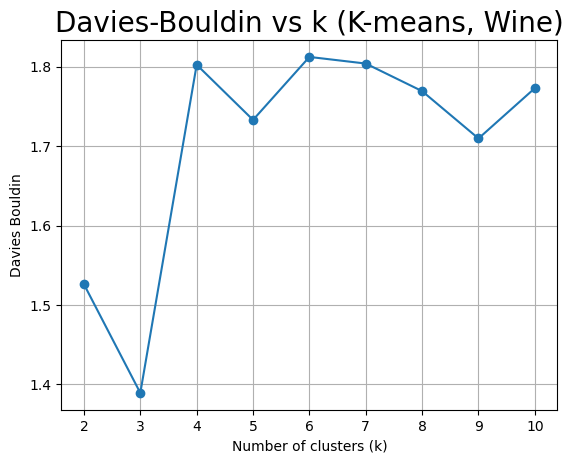

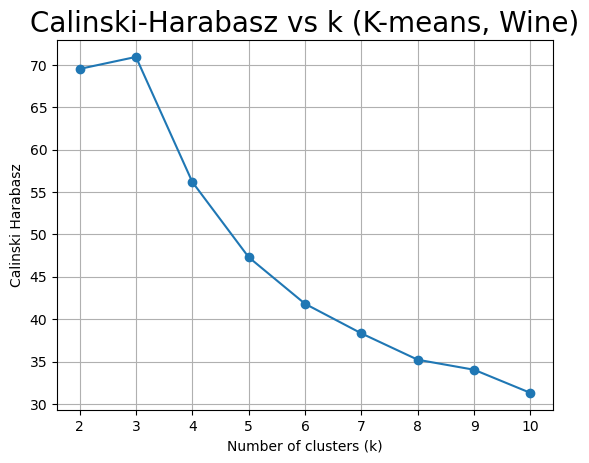

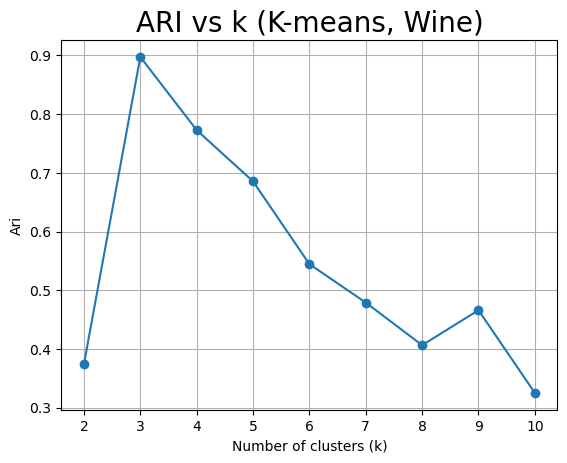

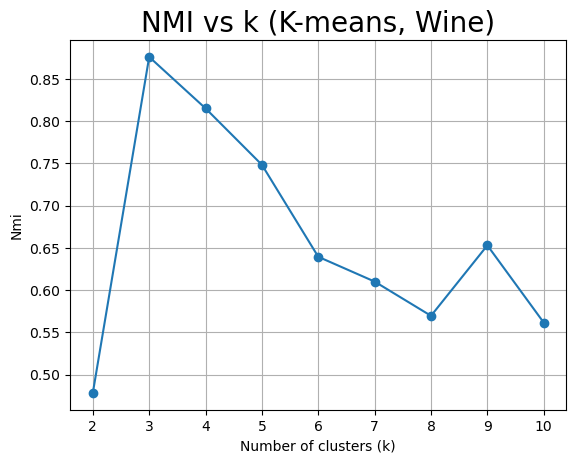

Best k by silhouette (Wine): k = 3, silhouette = 0.2849


In [6]:
'''WINE - Run KMeans for different k + plot metrics'''

k_values = range(2, 11)  # [2..10]
df_wine_metrics = kmeans_over_k(X_wine_std, y=y_wine, k_values=k_values, n_init=30, random_state=RANDOM_STATE)
display(df_wine_metrics)

df_wine_metrics.to_csv(wine_dir / "wine_kmeans_metrics.csv", index=False)

plot_metric_vs_k(df_wine_metrics, "inertia", "Elbow (Inertia) vs k (Wine)", wine_dir / "wine_elbow_inertia.png")
plot_metric_vs_k(df_wine_metrics, "silhouette", "Silhouette score vs k (K-means, Wine)", wine_dir / "wine_silhouette_vs_k.png")
plot_metric_vs_k(df_wine_metrics, "davies_bouldin", "Davies-Bouldin vs k (K-means, Wine)", wine_dir / "wine_dbi_vs_k.png")
plot_metric_vs_k(df_wine_metrics, "calinski_harabasz", "Calinski-Harabasz vs k (K-means, Wine)", wine_dir / "wine_ch_vs_k.png")

# Optional (because Wine has labels)
plot_metric_vs_k(df_wine_metrics, "ARI", "ARI vs k (K-means, Wine)", wine_dir / "wine_ari_vs_k.png")
plot_metric_vs_k(df_wine_metrics, "NMI", "NMI vs k (K-means, Wine)", wine_dir / "wine_nmi_vs_k.png")

best_k_wine, best_s_wine = choose_best_k(df_wine_metrics, metric="silhouette")
print(f"Best k by silhouette (Wine): k = {best_k_wine}, silhouette = {best_s_wine:.4f}")


In [7]:
'''Summary table for your report (Part 1)'''

summary = pd.DataFrame([
    {"dataset": "Iris", "best_k_by_silhouette": best_k_iris, "best_silhouette": best_s_iris},
    {"dataset": "Wine", "best_k_by_silhouette": best_k_wine, "best_silhouette": best_s_wine},
])

display(summary)
summary.to_csv(OUT_DIR / "summary_best_k.csv", index=False)

print("Saved metric tables:")
print("-", (iris_dir / "iris_kmeans_metrics.csv").as_posix())
print("-", (wine_dir / "wine_kmeans_metrics.csv").as_posix())
print("-", (OUT_DIR / "summary_best_k.csv").as_posix())


,dataset,best_k_by_silhouette,best_silhouette
0,Iris,2,0.581750
1,Wine,3,0.284859


Saved metric tables:
- outputs_part1_kmeans/iris/iris_kmeans_metrics.csv
- outputs_part1_kmeans/wine/wine_kmeans_metrics.csv
- outputs_part1_kmeans/summary_best_k.csv
